In [7]:
#install necessary libraries for distance and dimensionality reduction tasks

IS_COLAB = True

if IS_COLAB:
    !pip install tcrdist3
    !pip install umap-learn
    !pip install umap-learn[plot]

In [8]:
if IS_COLAB:
    from google.colab import drive

    drive.mount('/content/drive')
    %ls
    %cd drive/MyDrive/dsmp-2024-groupol1/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data/                   modelling.ipynb   results/                   visualisations/
giana_clustering.ipynb  README.md         tcr_bert_clustering.ipynb
metrics.py              requirements.txt  utilities/
[Errno 2] No such file or directory: 'drive/MyDrive/dsmp-2024-groupol1/'
/content/drive/MyDrive/dsmp-2024-groupol1


In [9]:
import pandas as pd

df = pd.read_csv('data/vdjdb.txt', sep="\t")


selected_features = df[['gene','cdr3','v.segm','j.segm','species','mhc.a','mhc.b','mhc.class','antigen.epitope','antigen.species','vdjdb.score', 'complex.id']]

# Select all human data
human_data = selected_features[(selected_features['species'] == 'HomoSapiens') & (selected_features['vdjdb.score'] > 0)]

# Drop duplicate rows
human_data_cols = human_data.columns.difference(['complex.id', 'vdjdb.score'])
print(human_data_cols)
human_data = human_data.drop_duplicates(subset=human_data_cols)

# Delete rows with null values
human_data  = human_data.dropna()
# Print all data
human_data.head()

Index(['antigen.epitope', 'antigen.species', 'cdr3', 'gene', 'j.segm', 'mhc.a',
       'mhc.b', 'mhc.class', 'species', 'v.segm'],
      dtype='object')


,gene,cdr3,v.segm,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,antigen.species,vdjdb.score,complex.id
0,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2,1
1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2,1
2,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2,0
3,TRA,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2,2
4,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2,2


In [10]:
human_data[human_data['cdr3'] == 'CALSSRGSTLGRLYF']

,gene,cdr3,v.segm,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,antigen.species,vdjdb.score,complex.id
78121,TRA,CALSSRGSTLGRLYF,TRAV19*01,TRAJ18*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,RMEQVDWTV,synthetic,2,27010
78123,TRA,CALSSRGSTLGRLYF,TRAV19*01,TRAJ18*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,KLEFMDWRL,synthetic,2,27011
78125,TRA,CALSSRGSTLGRLYF,TRAV19*01,TRAJ18*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,WLDNFELCL,synthetic,2,27012
78127,TRA,CALSSRGSTLGRLYF,TRAV19*01,TRAJ18*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,TLEYMDWLV,synthetic,2,27013
78129,TRA,CALSSRGSTLGRLYF,TRAV19*01,TRAJ18*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,EMMLFDWKV,synthetic,2,27014
78131,TRA,CALSSRGSTLGRLYF,TRAV19*01,TRAJ18*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,KLEQLDWTV,HomoSapiens,2,27015
78133,TRA,CALSSRGSTLGRLYF,TRAV19*01,TRAJ18*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,TMETIDWKV,HomoSapiens,2,27016
78135,TRA,CALSSRGSTLGRLYF,TRAV19*01,TRAJ18*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,TLEELDWCL,HomoSapiens,2,27017
78137,TRA,CALSSRGSTLGRLYF,TRAV19*01,TRAJ18*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,LLEDLDWDV,HomoSapiens,2,27018
78139,TRA,CALSSRGSTLGRLYF,TRAV19*01,TRAJ18*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,VLEEVDWLI,HomoSapiens,2,27019


In [11]:
TRB = human_data[human_data['gene'] =='TRB']
# rename the columns for our beta chain matrix calculation
beta_chains = TRB[['cdr3', 'v.segm', 'j.segm', 'antigen.epitope']]
beta_chains.rename(columns={'cdr3':'cdr3_b_aa','v.segm':'v_b_gene', 'j.segm':'j_b_gene'}, inplace=True)
beta_chains

<ipython-input-11-cdd9bf07a97a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beta_chains.rename(columns={'cdr3':'cdr3_b_aa','v.segm':'v_b_gene', 'j.segm':'j_b_gene'}, inplace=True)


,cdr3_b_aa,v_b_gene,j_b_gene,antigen.epitope
1,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
2,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
4,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
6,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
8,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,FLKEKGGL
...,...,...,...,...
92682,CASSLRATDTQYF,TRBV7-2*01,TRBJ2-3*01,PQPELPYPQPQL
92684,CATSRAGGGGEKLFF,TRBV15*01,TRBJ1-4*01,FPQPEQPFPWQP
92686,CASSQGSGGNEQFF,TRBV4-3*01,TRBJ2-1*01,FPQPEQPFPWQP
92690,CASSIVGSGGYNEQFF,TRBV19*01,TRBJ2-1*01,QLQPFPQPELPY


/usr/local/lib/python3.10/dist-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/usr/local/lib/python3.10/dist-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
/usr/local/lib/python3.10/dist-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/usr/local/lib/python3.10/dist-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

  ELAGIGILTV       0.00      0.00      0.00         0
   GILGFVFTL       0.17      0.14      0.15        51
   GLCTLVAML       0.14      0.22      0.17        23
   NLVPMVATV       0.66      0.39      0.49       143
    RAKFKQLL       0.03      0.33      0.06         3

    accuracy                           0.31       220
   macro avg       0.20      0.22      0.18       220
weighted avg       0.48      0.31      0.37       220

0.31363636363636366


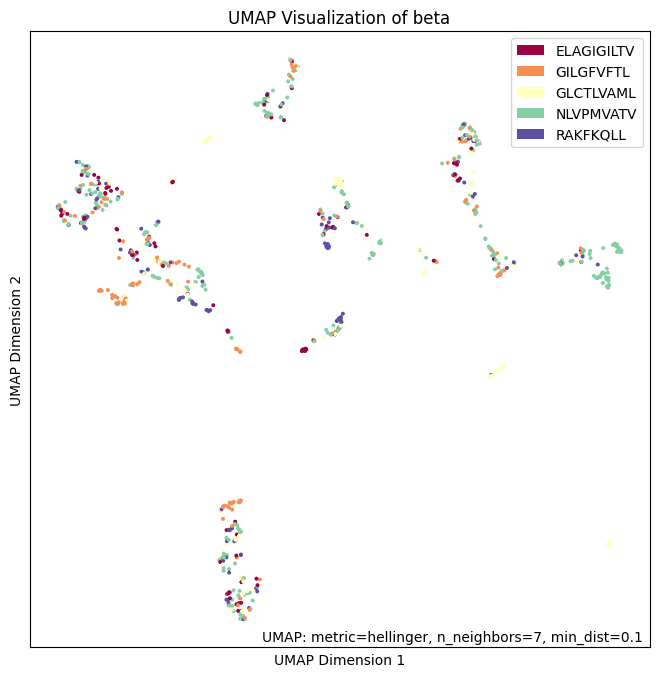

In [12]:
from utilities.utils import calculate_dist_and_umap

beta_dist_matrix = calculate_dist_and_umap(beta_chains, ['beta'], 'antigen.epitope')